In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import math
from neurodynex. tools import input_factory


WARNING    __main__:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
 [py.warnings]


nr of spikes: 190400


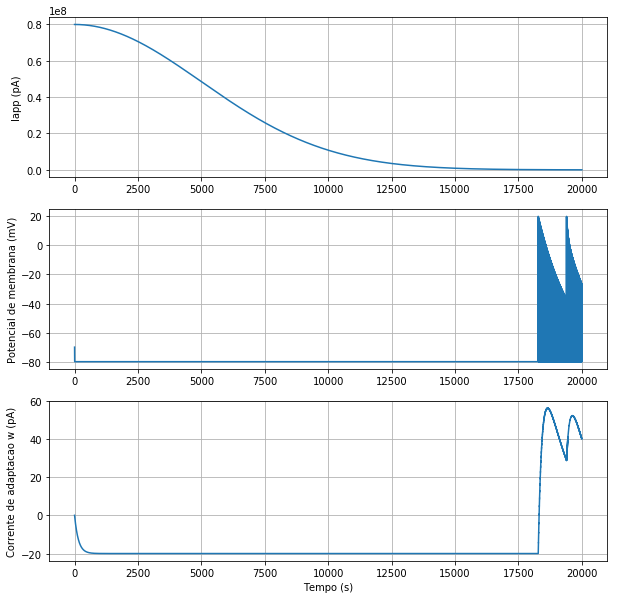

In [22]:
v_rest= -70*b2.mV #EL
v_reset= -80*b2.mV #Vreset
conductance_L = 10*b2.nsiemens #GL
membrane_capacitance = 100*b2.pF #CM
firing_threshold = -50 * b2.mV #Vth
deltaVth = 2*b2.mV

a = 2*b2.nsiemens
b = 0*b2.nA

tau_w = 150*b2.ms
v_max = 20*b2.mV

simulation_time = 20000
dt =  0.01*b2.ms 

#current = 200.01 * b2.pamp
current = 500*b2.pA
# input_current = input_factory.get_step_current(
# t_start=500, t_end=1000, unit_time=b2.ms,
# amplitude=current*b2.pA) 

append_zero=True
t_start=0
t_end=simulation_time
sigma = 50*(b2.pA*(b2.second**0.5))
dt_cur = 0.01
sigma = sigma/(dt**0.5)
mi=0
unit_time=b2.ms

tmp_size = 1 + t_end  # +1 for t=0
if append_zero:
    tmp_size += 1
tmp = np.zeros((tmp_size/dt_cur, 1)) * b2.pA

x = np.linspace(0, t_end+1, tmp_size/dt_cur) * b2.pA
normal = np.asarray(((1/np.sqrt(2*math.pi*sigma**2))*math.e**(-((x-mi)**2)/(2*sigma**2))))
normal = normal*b2.pA  
tmp[t_start: tmp_size/dt_cur + 1, 0] = normal

input_current = b2.TimedArray(tmp, dt=dt)
    
# differential equation of Leaky Integrate-and-Fire model
eqs = """

dv/dt = (conductance_L/membrane_capacitance)*
        (v_rest - v + deltaVth*exp((v-firing_threshold)/deltaVth))
        - (w/membrane_capacitance)
        + (input_current(t,i)/membrane_capacitance) : volt
dw/dt = (a*(v-v_rest)-w)/tau_w :  amp
"""
neuron = b2.NeuronGroup(1, model=eqs, reset="v=v_reset; w=w+b",
                        threshold="v>v_max", method="euler")
neuron.v = v_rest
neuron.w = 0*b2.pA

# monitoring membrane potential of neuron and injecting current
state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
spike_monitor = b2.SpikeMonitor(neuron)
# run the simulation
b2.run(simulation_time*b2.ms)

print("nr of spikes: {}".format(spike_monitor.count[0]))
#print("spikes times: {}".format(spike_monitor.t[:]))

#plot
fig = plt.figure(figsize=(10,10))

fig.add_subplot(3,1,1)
c = input_current(state_monitor.t, 0)
plt.plot(state_monitor.t/b2.ms, c/b2.pA )
plt.ylabel('Iapp (pA)')
plt.grid()

fig.add_subplot(3,1,2)
plt.plot(state_monitor.t/b2.ms, state_monitor.v[0]/b2.mV)

plt.ylabel('Potencial de membrana (mV)')
plt.grid()
#plt.legend(["vm", "firing threshold"], fontsize=12)

fig.add_subplot(3,1,3)
plt.plot(state_monitor.t/b2.ms, state_monitor.w[0]/b2.pA)
plt.grid()
plt.xlabel('Tempo (s)')
plt.ylabel('Corrente de adaptacao w (pA)')

plt.show()

In [ ]:
v_rest= -75*b2.mV #EL
v_reset= -80*b2.mV #Vreset
conductance_L = 10*b2.nsiemens #GL
membrane_capacitance = 100*b2.pF #CM
firing_threshold = -50 * b2.mV #Vth
deltaVth = 2*b2.mV

a = 2*b2.nsiemens
b = 0.02*b2.nA

tau_w = 200*b2.ms
v_max = 20*b2.mV

simulation_time = 5

input_current = np.arange(290, 600, 10)

eqs = """
dv/dt = (conductance_L/membrane_capacitance)*
        (v_rest - v + deltaVth*exp((v-firing_threshold)/deltaVth))
        - (w/membrane_capacitance)
        + (input_current/membrane_capacitance) : volt
dw/dt = (a/tau_w) * (v - v_rest) - (w/tau_w) : ampere
input_current : amp
"""
neuron = b2.NeuronGroup(len(input_current), model=eqs, 
                        reset="v=v_reset; w=w+b", 
                        threshold="v>v_max", method="euler")
neuron.v = v_rest
neuron.w = 0*b2.pA
neuron.input_current = input_current*b2.pA

# monitoring membrane potential of neuron and injecting current
state_monitor = b2.StateMonitor(neuron, ["v","w"], record=True)
spike_monitor = b2.SpikeMonitor(neuron)
# run the simulation
b2.run(simulation_time*b2.second)



In [ ]:
#plot
plt.figure(1)

first_inter = [None]*len(input_current)
stationary_inter = [None]*len(input_current)
for i in range(len(input_current)):
    first_inter[i] = 1/(float(spike_monitor.spike_trains()[i][2])
                        - float(spike_monitor.spike_trains()[i][1]))
    
    stationary_inter[i] = 1/(float(spike_monitor.spike_trains()[i][-2])
                             - float(spike_monitor.spike_trains()[i][-3]))

#plt.plot(neuron.current/b2.pA, spike_monitor.count/simulation_time, '*', label='count')
plt.plot(neuron.input_current/b2.pA, first_inter/b2.second, 'o', label='first_inter')
plt.plot(neuron.input_current/b2.pA, stationary_inter/b2.second, label='stationary_inter')
plt.xlabel('I (nA)')
plt.ylabel('Firing rate (sp/s)')
plt.legend()
plt.grid()
plt.show()#%%
